In [2]:
!git clone https://github.com/zhn66776/Tidal_try.git

Cloning into 'Tidal_try'...
remote: Enumerating objects: 1364, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 1364 (delta 58), reused 26 (delta 25), pack-reused 1280 (from 3)
Receiving objects: 100% (1364/1364), 142.19 MiB | 14.45 MiB/s, done.
Resolving deltas: 100% (617/617), done.
Updating files: 100% (363/363), done.


In [3]:
cd Tidal_try

/content/Tidal_try


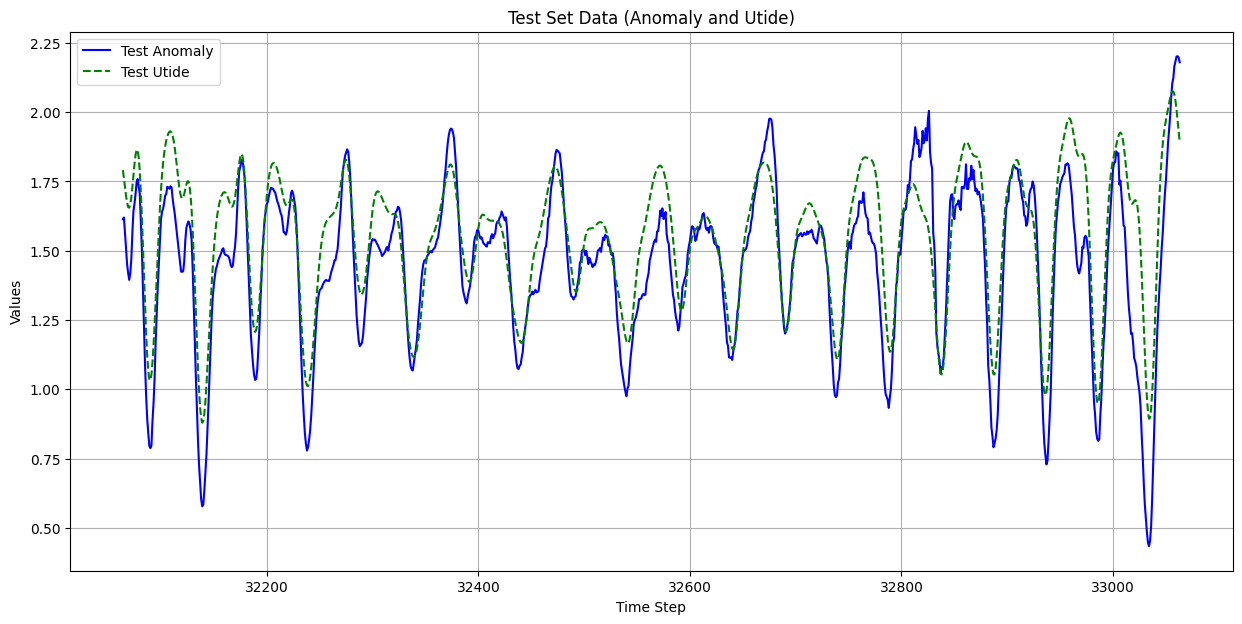

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
input_file = "dataProcessed/BOU2019_HA.csv"
df = pd.read_csv(input_file, delimiter=',')

total_train = 31964
look_back = 100
show_points = 1000
total_test = 2976
start_index = 0


test_start_index = start_index + total_train + look_back
test_end_index = test_start_index + show_points

test_anomaly = df['anomaly'][test_start_index:test_end_index].values
test_utide = df['tide_h'][test_start_index:test_end_index].values

plt.figure(figsize=(15, 7))
plt.plot(range(test_start_index, test_end_index), test_anomaly, label='Test Anomaly', color='blue')
plt.plot(range(test_start_index, test_end_index), test_utide, label='Test Utide', color='green', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Values')
plt.title('Test Set Data (Anomaly and Utide)')
plt.legend()
plt.grid(True)
plt.show()

Training BiLSTM_2feat multi-output (utide_factor=1, future_steps=27)...
Epoch 1/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.1516 - val_loss: 0.0354 - learning_rate: 0.0010
Epoch 2/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0357 - val_loss: 0.0182 - learning_rate: 0.0010
Epoch 3/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0206 - val_loss: 0.0116 - learning_rate: 0.0010
Epoch 4/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0141 - val_loss: 0.0082 - learning_rate: 0.0010
Epoch 5/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0105 - val_loss: 0.0062 - learning_rate: 0.0010
Epoch 6/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0082 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 7/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0067 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 8/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0057 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 9/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 

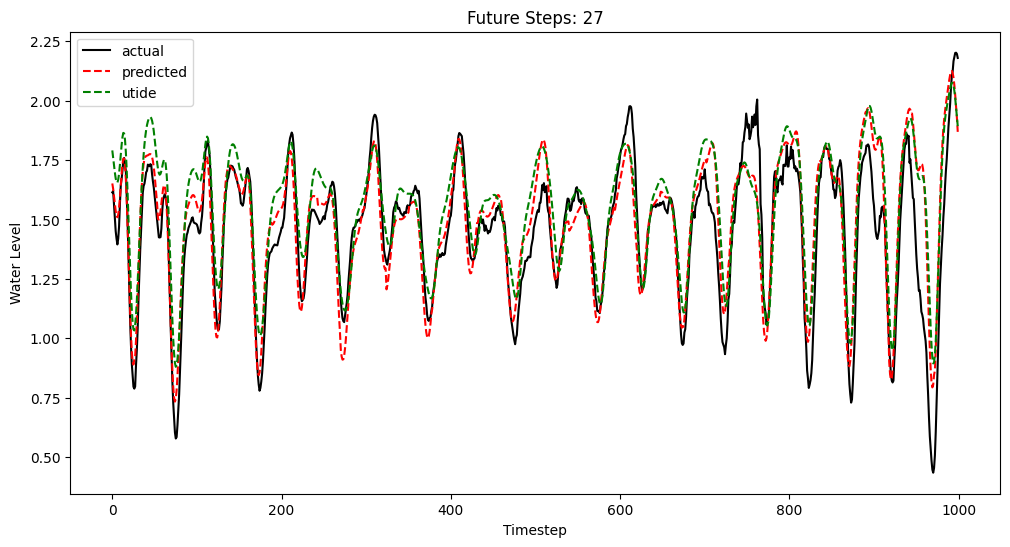

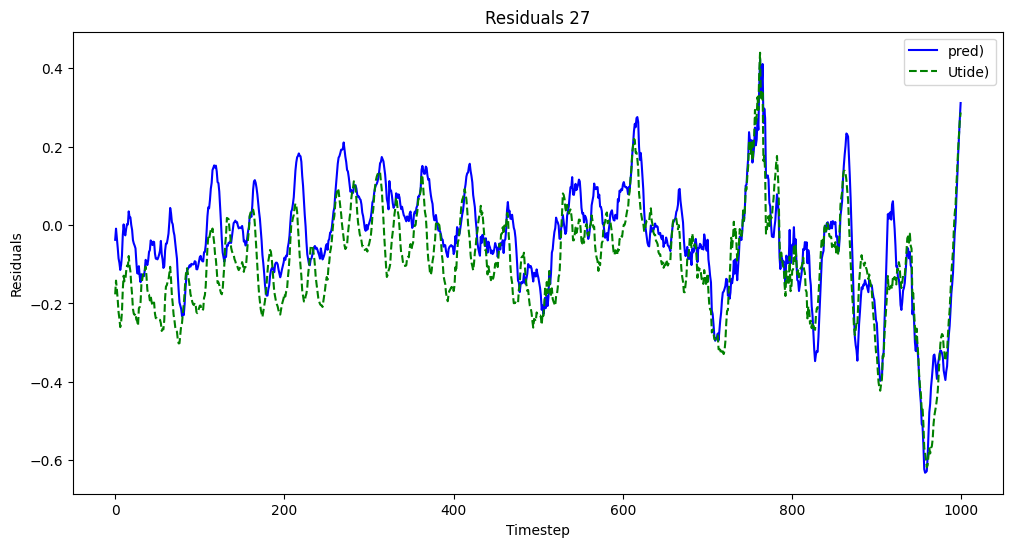

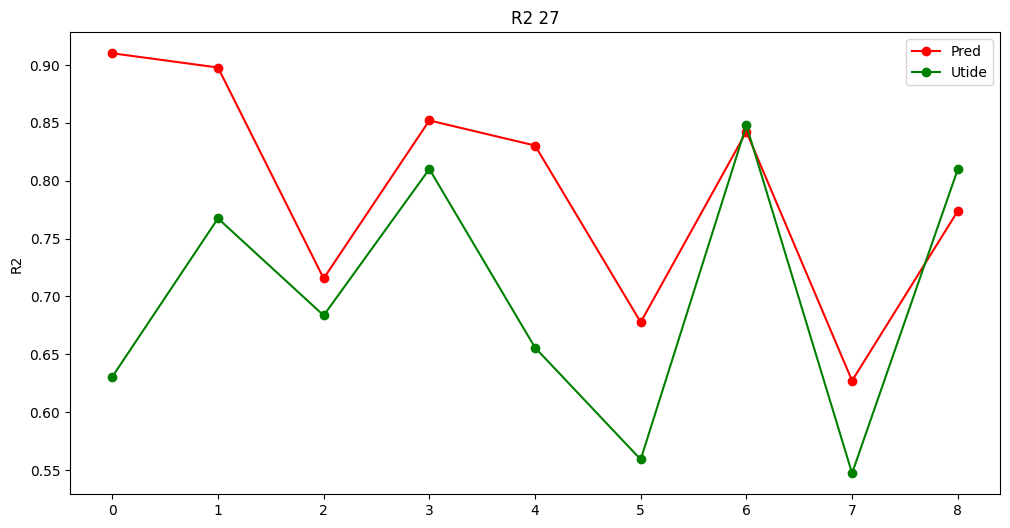

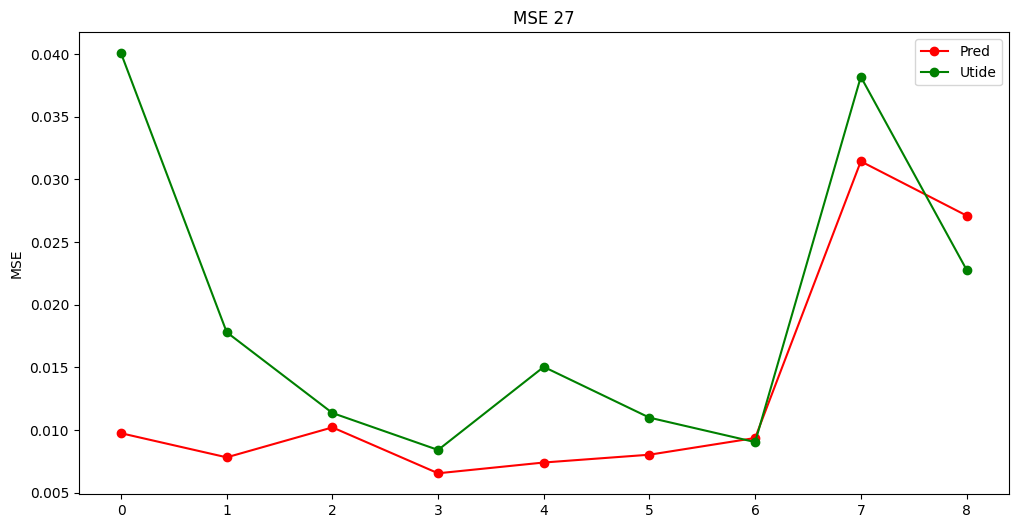

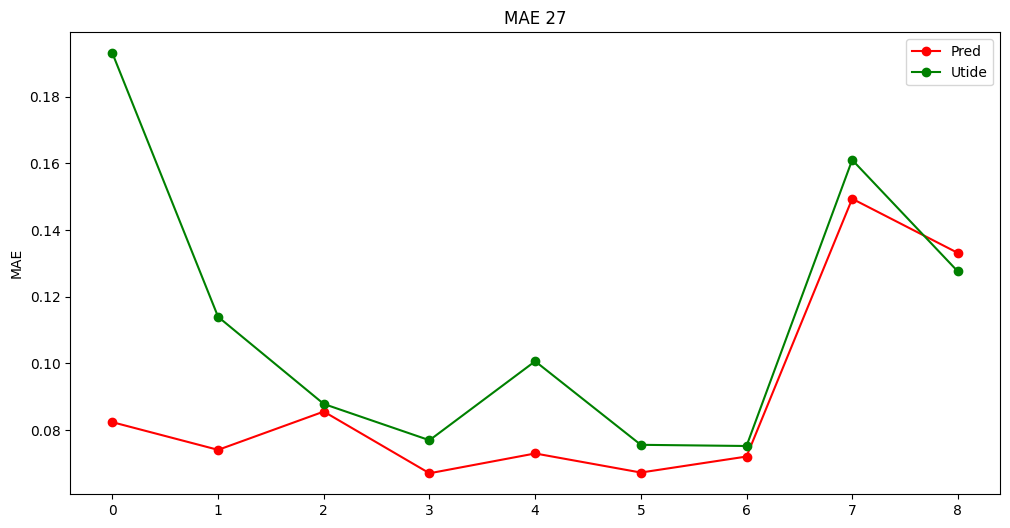

In [7]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Input
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
#random seed to ensure the same results in all experiments
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(3407)
np.random.seed(3407)
tf.random.set_seed(3407)
#input
input_file = "dataProcessed/BOU2019_HA.csv"
df = pd.read_csv(input_file, delimiter=',')

total_train = 31964
look_back = 100
total_test = 2976
start_index = 0
utide_factor = 1
future_steps_list = [27]

total_required = total_train + look_back + total_test
df_sampled = df.iloc[start_index:start_index + total_required].reset_index(drop=True)
#preprocess
anomaly = df_sampled['anomaly'].values.reshape(-1, 1)
utide_original = df_sampled['tide_h'].values.reshape(-1, 1)
utide_adjusted = utide_original * utide_factor
#scalar
scaler_anomaly_train = MinMaxScaler(feature_range=(0, 1))
scaler_utide_train = MinMaxScaler(feature_range=(0, 1))
scaler_anomaly_train.fit(anomaly)
scaler_utide_train.fit(utide_adjusted)

anomaly_scaled = scaler_anomaly_train.transform(anomaly)
utide_scaled = scaler_utide_train.transform(utide_adjusted)
dataset_scaled_multi = np.hstack((anomaly_scaled, utide_scaled))

train_multi = dataset_scaled_multi[:total_train]
test_multi = dataset_scaled_multi[total_train: total_train + total_test + look_back]
#create dataset
def dataset1(dataset, look_back, future_steps):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - future_steps + 1):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        future_values = [dataset[i + look_back + j, 0] for j in range(future_steps)]
        dataY.append(future_values)
    return np.array(dataX), np.array(dataY)

def inverse_anomaly(arr_scaled):
    arr_scaled = arr_scaled.reshape(-1, 1)
    return scaler_anomaly_train.inverse_transform(arr_scaled).flatten()

def inverse_utide(arr_scaled):
    arr_scaled = arr_scaled.reshape(-1, 1)
    utide_factor_domain = scaler_utide_train.inverse_transform(arr_scaled).flatten()
    return utide_factor_domain / utide_factor

#model
def ubilstm(input_shape, future_steps):
    input_layer = Input(shape=input_shape)
    x = Bidirectional(LSTM(100, return_sequences=True, kernel_regularizer=l2(0.0001)))(input_layer)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(100, return_sequences=True, kernel_regularizer=l2(0.0001)))(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(100, kernel_regularizer=l2(0.0001)))(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(future_steps)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

results = []

for future_steps in future_steps_list:
    trainX_multi, trainY_multi = dataset1(train_multi, look_back, future_steps)
    testX_multi, testY_multi = dataset1(test_multi, look_back, future_steps)
    trainX, valX, trainY, valY = train_test_split(trainX_multi, trainY_multi, test_size=0.1, random_state=3407)


    model = ubilstm((look_back, 2), future_steps)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)
    epochs = 80
    batch_size = 256

    print(f"Training BiLSTM_2feat multi-output (utide_factor={utide_factor}, future_steps={future_steps})...")
    model.fit(trainX, trainY, validation_data=(valX, valY), epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[reduce_lr])
    print("Training completed.\n")

    # rolling
    current_input = test_multi[:look_back].copy()
    pred_scaled = []
    actual_scaled = []
    utide_scaled_arr = []

    pred_points = 0
    while pred_points < total_test:
        input_sequence = current_input.reshape(1, look_back, 2)
        future_pred_scaled = model.predict(input_sequence, verbose=0)[0]

        for step_i in range(future_steps):
            if pred_points >= total_test:
                break
            pred_scaled.append(future_pred_scaled[step_i])
            actual_scaled_val = test_multi[look_back + pred_points, 0]
            utide_scaled_val = test_multi[look_back + pred_points, 1]
            actual_scaled.append(actual_scaled_val)
            utide_scaled_arr.append(utide_scaled_val)
            current_input = np.roll(current_input, -1, axis=0)
            current_input[-1, 0] = future_pred_scaled[step_i]
            if pred_points + 1 < total_test:
                current_input[-1, 1] = test_multi[look_back + pred_points + 1, 1]
            else:
                current_input[-1, 1] = test_multi[look_back + pred_points, 1]

            pred_points += 1

    #inverse
    pred_anomaly = inverse_anomaly(np.array(pred_scaled))
    actual_anomaly = inverse_anomaly(np.array(actual_scaled))
    actual_utide = inverse_utide(np.array(utide_scaled_arr))
    residuals_predicted = actual_anomaly[:1000] - pred_anomaly[:1000]
    residuals_utide = actual_anomaly[:1000] - actual_utide[:1000]

    plt.figure(figsize=(12, 6))
    plt.plot(actual_anomaly[:1000], label='actual', color='black')
    plt.plot(pred_anomaly[:1000], label='predicted', color='red', linestyle='--')
    plt.plot(actual_utide[:1000], label='utide', color='green', linestyle='--')
    plt.title(f'Future Steps: {future_steps}')
    plt.xlabel('Timestep')
    plt.ylabel('Water Level')
    plt.legend()
    plt.show()

    #residual
    plt.figure(figsize=(12, 6))
    plt.plot(residuals_predicted, label='pred)', color='blue')
    plt.plot(residuals_utide, label='Utide)', color='green', linestyle='--')
    plt.title(f'Residuals {future_steps}')
    plt.xlabel('Timestep')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()

    #every 100 step
    num_segments = 9
    segment_length = 100
    segment_labels = []
    r2_pred_list, mse_pred_list, mae_pred_list = [], [], []
    r2_utide_list, mse_utide_list, mae_utide_list = [], [], []

    for seg_i in range(num_segments):
        start = seg_i * segment_length
        end = start + segment_length

        seg_actual = actual_anomaly[start:end]
        seg_pred = pred_anomaly[start:end]
        seg_utide = actual_utide[start:end]

        r2_pred = r2_score(seg_actual, seg_pred)
        mse_pred = mean_squared_error(seg_actual, seg_pred)
        mae_pred = mean_absolute_error(seg_actual, seg_pred)

        r2_utide = r2_score(seg_actual, seg_utide)
        mse_utide = mean_squared_error(seg_actual, seg_utide)
        mae_utide = mean_absolute_error(seg_actual, seg_utide)

        r2_pred_list.append(r2_pred)
        mse_pred_list.append(mse_pred)
        mae_pred_list.append(mae_pred)

        r2_utide_list.append(r2_utide)
        mse_utide_list.append(mse_utide)
        mae_utide_list.append(mae_utide)

        segment_labels.append(f'{start}-{end}')

    #R2
    plt.figure(figsize=(12,6))
    x = np.arange(num_segments)
    plt.plot(x, r2_pred_list, marker='o', color='red', label='Pred')
    plt.plot(x, r2_utide_list, marker='o', color='green', label='Utide')
    plt.title(f'R2 {future_steps}')
    plt.ylabel('R2')
    plt.legend()
    plt.show()

    #MSE
    plt.figure(figsize=(12,6))
    plt.plot(x, mse_pred_list, marker='o', color='red', label='Pred')
    plt.plot(x, mse_utide_list, marker='o', color='green', label='Utide')
    plt.title(f'MSE {future_steps}')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

    #MAE
    plt.figure(figsize=(12,6))
    plt.plot(x, mae_pred_list, marker='o', color='red', label='Pred')
    plt.plot(x, mae_utide_list, marker='o', color='green', label='Utide')
    plt.title(f'MAE {future_steps}')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()


    for t, pred, actual, utide in zip(range(len(pred_anomaly)), pred_anomaly, actual_anomaly, actual_utide):
        results.append({
            'future_steps': future_steps,
            'Time_Step': t,
            'Predicted_Values': pred,
            'Actual_Values': actual,
            'Utide_Values': utide
        })


results_df = pd.DataFrame(results)

In [8]:

results_df = pd.DataFrame(results)
output_file = "BOUU2019_utide(111)27.csv"
results_df.to_csv(output_file, index=False)